In [1]:
from paretoKnapsackTeams import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}"
    })
else:
    mpl.rcParams.update({"text.usetex": False})

#Import datasets
#IMDB
imdb_experts_1, imdb_tasks_1, imdb_costs_1, imdb_graphmat_1 = import_pickled_datasets('imdb', 1)
imdb_experts_2, imdb_tasks_2, imdb_costs_2, imdb_graphmat_2 = import_pickled_datasets('imdb', 2)
# imdb_experts_3, imdb_tasks_3, imdb_costs_3, imdb_graphmat_3 = import_pickled_datasets('imdb', 3)

#Bibsonomy
bbsm_experts_1, bbsm_tasks_1, bbsm_costs_1, bbsm_graphmat_1 = import_pickled_datasets('bbsm', 1)
# bbsm_experts_2, bbsm_tasks_2, bbsm_costs_2, bbsm_graphmat_2 = import_pickled_datasets('bbsm', 2)
# bbsm_experts_3, bbsm_tasks_3, bbsm_costs_3, bbsm_graphmat_3 = import_pickled_datasets('bbsm', 3)

#Freelancer
fl_experts_1, fl_tasks_1, fl_costs_1, fl_graphmat_1 = import_pickled_datasets('freelancer', 1)
# fl_experts_2, fl_tasks_2, fl_costs_2, fl_graphmat_2 = import_pickled_datasets('freelancer', 2)

2026-02-02 16:46:24,085 |INFO: Imported imdb experts, Num Experts: 200
2026-02-02 16:46:24,086 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-02 16:46:24,087 |INFO: Imported imdb costs, Num Costs: 200
2026-02-02 16:46:24,091 |INFO: Imported imdb graph matrix, Shape: (1000, 1000)

2026-02-02 16:46:24,092 |INFO: Imported imdb experts, Num Experts: 400
2026-02-02 16:46:24,093 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-02 16:46:24,094 |INFO: Imported imdb costs, Num Costs: 400
2026-02-02 16:46:24,100 |INFO: Imported imdb graph matrix, Shape: (3000, 3000)

2026-02-02 16:46:24,102 |INFO: Imported bbsm experts, Num Experts: 250
2026-02-02 16:46:24,103 |INFO: Imported bbsm tasks, Num Tasks: 300
2026-02-02 16:46:24,104 |INFO: Imported bbsm costs, Num Costs: 250
2026-02-02 16:46:24,105 |INFO: Imported bbsm graph matrix, Shape: (500, 500)

2026-02-02 16:46:24,106 |INFO: Imported freelancer experts, Num Experts: 50
2026-02-02 16:46:24,107 |INFO: Imported freelancer tasks, Num Tasks: 25

### Single Task Plotting

In [2]:
def findSingleTaskSolutions(tasks_list, experts_list, costs_list,
                             sizeUniverse, numExperts, maxBudget,
                             dataset_name=None, task_index=0):
    '''
    Run algorithms for a single task and plot results (no averaging or interpolation).
    '''
    # Cost grid (same for all budgets within this task)
    num_steps, min_cost = 15, 5
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack", "CoverageLinear", "TopK"]

    def sort_pairs(costs, covs):
        if len(costs) == 0:
            return np.array([]), np.array([])
        pairs = sorted(zip(costs, covs), key=lambda x: x[0])
        return np.array([p[0] for p in pairs], dtype=float), np.array([p[1] for p in pairs], dtype=float)

    def format_points(costs, covs):
        return [f"({c:.2f}, {v:.3f})" for c, v in zip(costs, covs)]

    # Select task
    task = tasks_list[task_index]

    # Prefix Pareto + Coverage Linear (computed once at full budget)
    paretoTeams_full = paretoKnapsackTeams(task=task,
                                      n_experts=experts_list[:numExperts],
                                      costs=costs_list, size_univ=sizeUniverse,
                                      budget=maxBudget)
    pp1_costs, pp1_coverages, pp1_map, pp1_time = paretoTeams_full.prefixParetoGreedy_1Guess()
    cl_costs, cl_coverages, cl_map, cl_time = paretoTeams_full.coverage_linear()

    # Per-budget results
    coverages = {alg: [] for alg in algo_names}
    runtimes = {alg: [] for alg in algo_names}

    for budgetVal in cost_arr:
        paretoTeams = paretoKnapsackTeams(task=task,
                                     n_experts=experts_list[:numExperts],
                                     costs=costs_list, size_univ=sizeUniverse,
                                     budget=budgetVal)

        # Plain Greedy
        plainExperts, _, plainCov, plainCost, plainTime = paretoTeams.plainGreedy()
        coverages['PlainGreedy'].append(plainCov)
        runtimes['PlainGreedy'].append(plainTime)

        # Two Guess Plain Greedy
        _, _, tgCov, tgCost, tgTime = paretoTeams.twoGuessPlainGreedy()
        coverages['PlainGreedy-2Guess'].append(tgCov)
        runtimes['PlainGreedy-2Guess'].append(tgTime)

        # One Guess Greedy Plus
        _, _, ogCov, ogCost, ogTime = paretoTeams.oneGuessGreedyPlus()
        coverages['GreedyPlus-1Guess'].append(ogCov)
        runtimes['GreedyPlus-1Guess'].append(ogTime)

        # Top-k (use #experts chosen by PlainGreedy)
        k_val = max(1, len(plainExperts))
        _, _, tkCov, tkCost, tkTime = paretoTeams.top_k(k_val)
        coverages['TopK'].append(tkCov)
        runtimes['TopK'].append(tkTime)

    runtimes['ParetoGreedy-Knapsack'].append(pp1_time)
    runtimes['CoverageLinear'].append(cl_time)

    # Log pareto points per algorithm
    pg_costs, pg_covs = sort_pairs(pp1_costs, pp1_coverages)
    cl_costs_sorted, cl_covs_sorted = sort_pairs(cl_costs, cl_coverages)
    logging.info("Pareto points - ParetoGreedy-Knapsack: %s", format_points(pg_costs, pg_covs))
    logging.info("Pareto points - CoverageLinear: %s", format_points(cl_costs_sorted, cl_covs_sorted))
    logging.info("Pareto points - PlainGreedy: %s", format_points(cost_arr, coverages['PlainGreedy']))
    logging.info("Pareto points - PlainGreedy-2Guess: %s", format_points(cost_arr, coverages['PlainGreedy-2Guess']))
    logging.info("Pareto points - GreedyPlus-1Guess: %s", format_points(cost_arr, coverages['GreedyPlus-1Guess']))
    logging.info("Pareto points - TopK: %s", format_points(cost_arr, coverages['TopK']))

    # Plot
    colors = plt.get_cmap("tab10").colors
    marker_map = {
        "ParetoGreedy-Knapsack": "D",
        "CoverageLinear": "o",
        "PlainGreedy": "s",
        "PlainGreedy-2Guess": "^",
        "GreedyPlus-1Guess": "v",
        "TopK": "P"
    }
    marker_sizes = {"ParetoGreedy-Knapsack": 8, "CoverageLinear": 7, "PlainGreedy": 6, "PlainGreedy-2Guess": 6, "GreedyPlus-1Guess": 6, "TopK": 7}
    linestyle_map = {"ParetoGreedy-Knapsack": '-', "CoverageLinear": '-', "PlainGreedy": ':', "PlainGreedy-2Guess": '--', "GreedyPlus-1Guess": '-.', "TopK": ':'}
    zorder_map = {"ParetoGreedy-Knapsack": 6, "CoverageLinear": 5, "TopK": 4, "GreedyPlus-1Guess": 3, "PlainGreedy-2Guess": 2, "PlainGreedy": 1}
    alpha_map = {"ParetoGreedy-Knapsack": 1.0, "CoverageLinear": 0.95, "TopK": 0.9, "GreedyPlus-1Guess": 0.9, "PlainGreedy-2Guess": 0.9, "PlainGreedy": 0.9}
    mfc_map = {"ParetoGreedy-Knapsack": None, "CoverageLinear": "white", "TopK": "white", "GreedyPlus-1Guess": None, "PlainGreedy-2Guess": "white", "PlainGreedy": None}

    series_map = {
        "ParetoGreedy-Knapsack": sort_pairs(pp1_costs, pp1_coverages),
        "CoverageLinear": sort_pairs(cl_costs, cl_coverages),
        "PlainGreedy": (cost_arr, np.array(coverages['PlainGreedy'], dtype=float)),
        "PlainGreedy-2Guess": (cost_arr, np.array(coverages['PlainGreedy-2Guess'], dtype=float)),
        "GreedyPlus-1Guess": (cost_arr, np.array(coverages['GreedyPlus-1Guess'], dtype=float)),
        "TopK": (cost_arr, np.array(coverages['TopK'], dtype=float))
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    for i, alg in enumerate(algo_names):
        color = colors[i % len(colors)]
        marker = marker_map.get(alg, 'o')
        label = rf"\texttt{{{alg}}}"
        label_map[alg] = label
        x_vals, y_vals = series_map[alg]
        ax.plot(x_vals, y_vals,
                label=label,
                color=color,
                linestyle=linestyle_map.get(alg, ':'),
                marker=marker,
                markersize=marker_sizes.get(alg, 6),
                markeredgewidth=1.2,
                markeredgecolor='k',
                markerfacecolor=(mfc_map.get(alg) if mfc_map.get(alg) is not None else color),
                linewidth=1.8,
                alpha=alpha_map.get(alg, 0.9),
                zorder=zorder_map.get(alg, 1))

    ax.set_xlabel(r'Team cost ($c_\ell$)', fontsize=28)
    ax.set_ylabel(r'Task coverage ($f$)', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    ax.legend(fontsize=18)

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack" / "single_task"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack_single_task.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (seconds)
    runtime_lines = ["Runtime summary (seconds):"]
    for alg in algo_names:
        total_runtime = float(np.nansum(np.array(runtimes.get(alg, []), dtype=float)))
        runtime_lines.append(f"  - {alg}: {total_runtime:.3f}")
    logging.info("\n".join(runtime_lines))

## Freelancer-1

2026-02-02 16:46:26,258 |INFO: Pareto points - ParetoGreedy-Knapsack: ['(20.00, 0.250)', '(45.00, 0.500)', '(70.00, 0.750)', '(120.00, 1.000)']
2026-02-02 16:46:26,259 |INFO: Pareto points - CoverageLinear: ['(20.00, 0.250)', '(45.00, 0.500)', '(90.00, 0.750)', '(140.00, 1.000)']
2026-02-02 16:46:26,259 |INFO: Pareto points - PlainGreedy: ['(5.00, 0.000)', '(40.36, 0.250)', '(75.71, 0.500)', '(111.07, 0.750)', '(146.43, 1.000)', '(181.79, 1.000)', '(217.14, 1.000)', '(252.50, 1.000)', '(287.86, 1.000)', '(323.21, 1.000)', '(358.57, 1.000)', '(393.93, 1.000)', '(429.29, 1.000)', '(464.64, 1.000)', '(500.00, 1.000)']
2026-02-02 16:46:26,259 |INFO: Pareto points - PlainGreedy-2Guess: ['(5.00, 0.000)', '(40.36, 0.250)', '(75.71, 0.750)', '(111.07, 0.750)', '(146.43, 1.000)', '(181.79, 1.000)', '(217.14, 1.000)', '(252.50, 1.000)', '(287.86, 1.000)', '(323.21, 1.000)', '(358.57, 1.000)', '(393.93, 1.000)', '(429.29, 1.000)', '(464.64, 1.000)', '(500.00, 1.000)']
2026-02-02 16:46:26,260 |INF

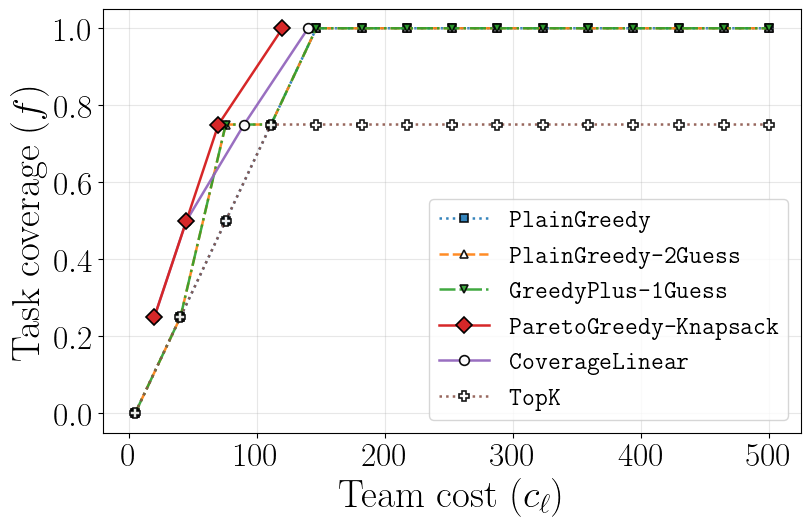

2026-02-02 16:46:26,976 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.002
  - PlainGreedy-2Guess: 1.807
  - GreedyPlus-1Guess: 0.294
  - ParetoGreedy-Knapsack: 0.006
  - CoverageLinear: 0.000
  - TopK: 0.001


In [3]:
findSingleTaskSolutions(tasks_list=fl_tasks_1, experts_list=fl_experts_1, costs_list=fl_costs_1,
                        sizeUniverse=50, numExperts=50, maxBudget=500,
                        dataset_name="Freelancer", task_index=0)

## IMDB

2026-02-02 16:46:34,564 |INFO: Pareto points - ParetoGreedy-Knapsack: ['(5.00, 0.625)', '(10.00, 0.750)', '(20.00, 0.875)', '(40.00, 1.000)']
2026-02-02 16:46:34,565 |INFO: Pareto points - CoverageLinear: ['(5.00, 0.125)', '(5.00, 0.250)', '(5.00, 0.375)', '(5.00, 0.500)', '(5.00, 0.625)', '(10.00, 0.750)', '(25.00, 0.875)', '(45.00, 1.000)']
2026-02-02 16:46:34,565 |INFO: Pareto points - PlainGreedy: ['(5.00, 0.625)', '(13.21, 0.750)', '(21.43, 0.750)', '(29.64, 0.875)', '(37.86, 0.875)', '(46.07, 1.000)', '(54.29, 1.000)', '(62.50, 1.000)', '(70.71, 1.000)', '(78.93, 1.000)', '(87.14, 1.000)', '(95.36, 1.000)', '(103.57, 1.000)', '(111.79, 1.000)', '(120.00, 1.000)']
2026-02-02 16:46:34,566 |INFO: Pareto points - PlainGreedy-2Guess: ['(5.00, 0.625)', '(13.21, 0.750)', '(21.43, 0.875)', '(29.64, 0.875)', '(37.86, 0.875)', '(46.07, 1.000)', '(54.29, 1.000)', '(62.50, 1.000)', '(70.71, 1.000)', '(78.93, 1.000)', '(87.14, 1.000)', '(95.36, 1.000)', '(103.57, 1.000)', '(111.79, 1.000)', '

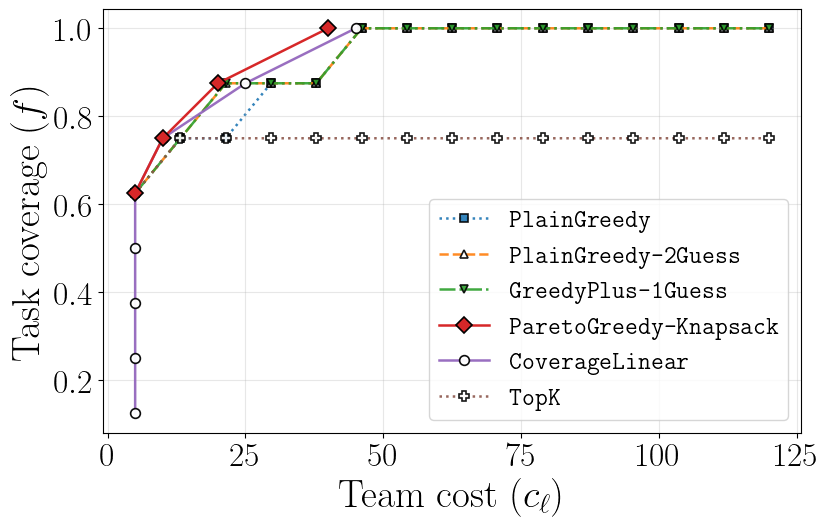

2026-02-02 16:46:34,872 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.012
  - PlainGreedy-2Guess: 6.751
  - GreedyPlus-1Guess: 0.718
  - ParetoGreedy-Knapsack: 0.070
  - CoverageLinear: 0.002
  - TopK: 0.002


In [4]:
findSingleTaskSolutions(tasks_list=imdb_tasks_1, experts_list=imdb_experts_1, costs_list=imdb_costs_1,
                        sizeUniverse=24, numExperts=150, maxBudget=120,
                        dataset_name="IMDB-1", task_index=0)

2026-02-02 16:46:50,306 |INFO: Pareto points - ParetoGreedy-Knapsack: ['(5.00, 0.444)', '(10.00, 0.667)', '(15.00, 0.778)', '(20.00, 1.000)']
2026-02-02 16:46:50,306 |INFO: Pareto points - CoverageLinear: ['(5.00, 0.111)', '(5.00, 0.222)', '(5.00, 0.333)', '(5.00, 0.444)', '(10.00, 0.556)', '(10.00, 0.667)', '(15.00, 0.778)', '(20.00, 0.889)', '(25.00, 1.000)']
2026-02-02 16:46:50,307 |INFO: Pareto points - PlainGreedy: ['(5.00, 0.444)', '(10.36, 0.667)', '(15.71, 0.778)', '(21.07, 0.889)', '(26.43, 1.000)', '(31.79, 1.000)', '(37.14, 1.000)', '(42.50, 1.000)', '(47.86, 1.000)', '(53.21, 1.000)', '(58.57, 1.000)', '(63.93, 1.000)', '(69.29, 1.000)', '(74.64, 1.000)', '(80.00, 1.000)']
2026-02-02 16:46:50,307 |INFO: Pareto points - PlainGreedy-2Guess: ['(5.00, 0.444)', '(10.36, 0.667)', '(15.71, 0.778)', '(21.07, 1.000)', '(26.43, 1.000)', '(31.79, 1.000)', '(37.14, 1.000)', '(42.50, 1.000)', '(47.86, 1.000)', '(53.21, 1.000)', '(58.57, 1.000)', '(63.93, 1.000)', '(69.29, 1.000)', '(74.

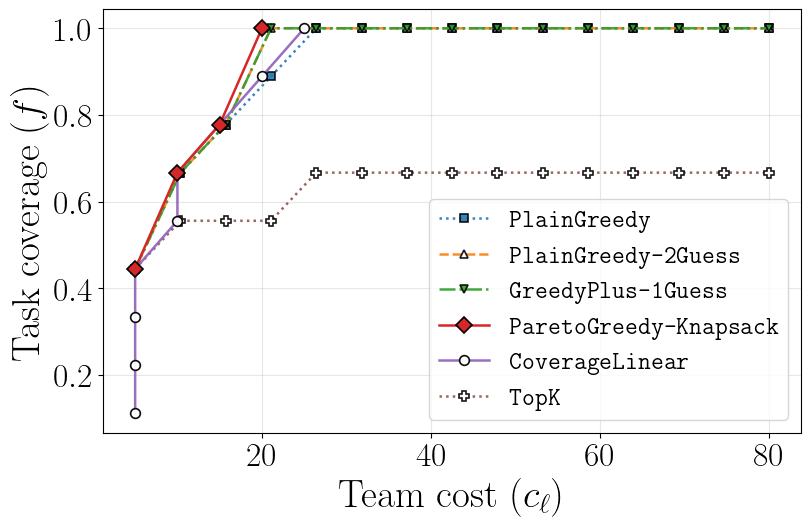

2026-02-02 16:46:50,600 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.016
  - PlainGreedy-2Guess: 13.949
  - GreedyPlus-1Guess: 1.300
  - ParetoGreedy-Knapsack: 0.112
  - CoverageLinear: 0.006
  - TopK: 0.002


In [5]:
findSingleTaskSolutions(tasks_list=imdb_tasks_2, experts_list=imdb_experts_2, costs_list=imdb_costs_2,
                        sizeUniverse=24, numExperts=300, maxBudget=80,
                        dataset_name="IMDB-2", task_index=0)

## Bbsm-1

2026-02-02 16:47:01,702 |INFO: Pareto points - ParetoGreedy-Knapsack: ['(5.00, 0.500)', '(10.00, 0.750)', '(20.00, 1.000)']
2026-02-02 16:47:01,703 |INFO: Pareto points - CoverageLinear: ['(5.00, 0.250)', '(5.00, 0.500)', '(15.00, 0.750)', '(25.00, 1.000)']
2026-02-02 16:47:01,703 |INFO: Pareto points - PlainGreedy: ['(5.00, 0.500)', '(10.00, 0.500)', '(15.00, 0.750)', '(20.00, 0.750)', '(25.00, 1.000)', '(30.00, 1.000)', '(35.00, 1.000)', '(40.00, 1.000)', '(45.00, 1.000)', '(50.00, 1.000)', '(55.00, 1.000)', '(60.00, 1.000)', '(65.00, 1.000)', '(70.00, 1.000)', '(75.00, 1.000)']
2026-02-02 16:47:01,703 |INFO: Pareto points - PlainGreedy-2Guess: ['(5.00, 0.500)', '(10.00, 0.750)', '(15.00, 0.750)', '(20.00, 1.000)', '(25.00, 1.000)', '(30.00, 1.000)', '(35.00, 1.000)', '(40.00, 1.000)', '(45.00, 1.000)', '(50.00, 1.000)', '(55.00, 1.000)', '(60.00, 1.000)', '(65.00, 1.000)', '(70.00, 1.000)', '(75.00, 1.000)']
2026-02-02 16:47:01,704 |INFO: Pareto points - GreedyPlus-1Guess: ['(5.00, 

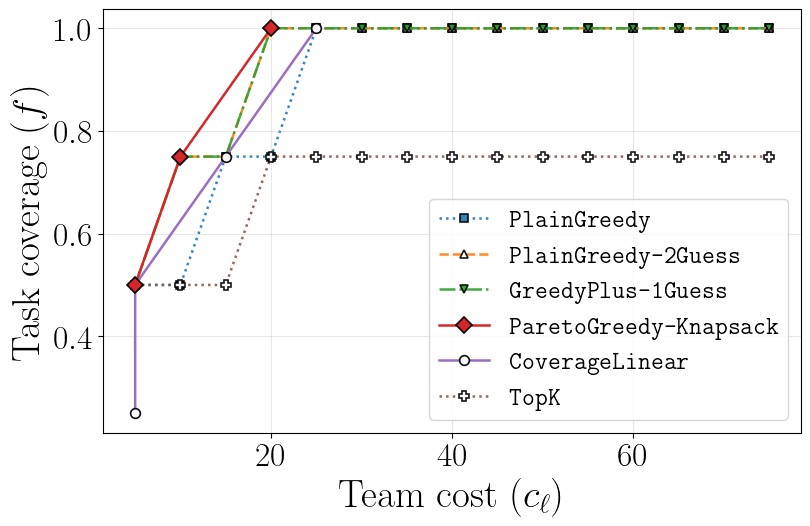

2026-02-02 16:47:01,985 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.012
  - PlainGreedy-2Guess: 9.946
  - GreedyPlus-1Guess: 0.978
  - ParetoGreedy-Knapsack: 0.104
  - CoverageLinear: 0.002
  - TopK: 0.002


In [6]:
findSingleTaskSolutions(tasks_list=bbsm_tasks_1, experts_list=bbsm_experts_1, costs_list=bbsm_costs_1,
                        sizeUniverse=75, numExperts=250, maxBudget=75,
                        dataset_name="Bbsm", task_index=0)